# Projection 2

We have seen how maths (and Python) can be used to transform coordinates in 2D and 3D. Projection is the process of representing all or part of a 3D object on a 2D screen. Projection shares some common features with 2D and 3D transformations: it commonly uses specific matrix forms in order to perform specific operations.

In this workbook we will consider the second of two different types of projection, and the resulting impact on the projected image.

In [17]:
## Libraries
import numpy as np
import math 
import matplotlib.pyplot as plt
import sympy as sym
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from sympy import sin, cos, Matrix

In [18]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)

## Perspective Projection



In the previous workbook we considered orthoganol projection, which preserves lines and angles to accurately reproduce 2D scale versions of a 3D object.

An alternative to this approach is *perspective projection* which modifies lines and angles of the object so that the projected image contains a sense of depth ("perspective"). These projections are less accurate, but are far more likely to be used by artists and gamers to aid realism and immersion. It is likely you have grown up attempting to draw 3D objects using a pen and paper: these pictures were almost certainly perspective projections!

In the lectures, we examined some simple perspective projection cases, before combining them together to create a general perspective transformation matrix:

$$
P_{\rm{er}}=
	\begin{pmatrix}
	d - (by_c+c*z_c) & -ay_c & az_c  & a \\
	bx_c  & d-(ax_c+cz_c)    & bz_c  & b \\
	cx_c  & cy_c     & d-(ax_c+by_c) & c \\
    -dx_c & -dy_c    & -dy_c & -(ax_c+by_c+cz_c)
	\end{pmatrix},
$$

which carries out a perspective projection from a viewing centre $(x_c,y_c,z_c)$ onto a plane with equation $ax+by+cz=d$.

We also learned that a projection is only possible when certain conditions are met; these conditions depend on the distance from the point(s) to be projected to the screen ($D_p$) and the distance from the viewing centre to the screen ($D_c$). A projection is only possible if

* ${\rm{sign}}(D_p)\neq{\rm{sign}}(D_c)$ or
* $|D_c|>|D_p|$ if ${\rm{sign}}(D_p)={\rm{sign}}(D_c)$.

This test uses the distance formula learned in lectures:

$$
D=\frac{ax+by+cz-d}{\sqrt{a^2+b^2+c^2}}.
$$


As usual with these workbooks I think we could use an illustrative example:

### Lecture Example:
**The points $(2,4,-1)$ and $(-3,6,4)$ are projected onto the plane $3x-y+z=5$ by a single point perspective projection, with viewing centre at $(2,3,4)$. Find the image of these points and hence determine the parametric equation of the line segment joining these images of the plane**.

This problem does not strictly ask us to test if the projection is possible, however, as programmers/engineers, we probably want to check this first before proceeding with the calculation (in case we go to a lot of trouble for a projection which wasn't possible in the first place!).

To begin, let's creating the array of points to project:

In [19]:
x_vals = np.array([2, -3])
y_vals = np.array([4, 6])
z_vals = np.array([-1, 4])
p = np.array([x_vals, y_vals, z_vals])
vc = np.array([2,3,4])

We can even view these points, and the line joining them, using Python:

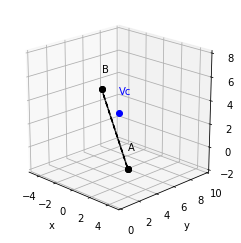

In [20]:
lx=np.append(x_vals,x_vals[0]) #drawing the line between the last and first coord
ly=np.append(y_vals,y_vals[0])
lz=np.append(z_vals,z_vals[0])
ax = plt.figure().add_subplot(projection='3d')
ax.view_init(elev=20, azim=315, roll=0)
ax.plot(lx, ly, lz, 'ko', linestyle="--")
ax.plot(x_vals, y_vals, z_vals, 'ko')
ax.plot(vc[0],vc[1],vc[2], 'bo')
ax.text(lx[0]-1, ly[0]+1, lz[0]+1, "A", c='k')
ax.text(lx[1]-1, ly[1]+1, lz[1]+1, "B", c='k')
ax.text(vc[0]-1, vc[1]+1, vc[2]+1, "Vc", c='b')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.axes.set_xlim3d(left=-5, right=5) 
ax.axes.set_ylim3d(bottom=0, top=10) 
ax.axes.set_zlim3d(bottom=-2, top=8)
plt.gca().set_aspect('equal')
plt.show()

We will create a matrix of positions in homogenous coordinates, ready to be transformed:

In [21]:
nr = [1 for x in range(len(x_vals))]
hp = np.vstack([p, nr])
print(hp.transpose())

[[ 2  4 -1  1]
 [-3  6  4  1]]


#### Projection Test

Let's now test if we can carry out this projection. Following the information in the lectures we now need to test the distance from the plane to the plane/screen.

Note that in the lectures, we only require the numerator of the distance formula to evaluate distances. This is because we are not calculating true distances, but comparing relative distances. Because we are using it for a comparison, the denominators don't matter (they are identical for all points, and only depend on values associated with the plane). However, here, I will include the denominator in the calculation for completeness.

*Try for yourselves: comment out the denominator from the formula for $Dp$ and $Dc$ in the code below, and verify it does not affect whether the projection is possible.*


In [22]:
a = 3
b = -1
c = 1
d = 5
denom = np.sqrt(a*a+b*b+c*c)
dp = (a*x_vals+b*y_vals+c*z_vals-d)/denom
print("dp=", dp)
dc = (a*vc[0]+b*vc[1]+c*vc[2]-d)/denom
print("dc=",dc)

dp= [-1.20604538 -4.82418151]
dc= 0.6030226891555273


Printing the values to the screen, we can see that the signs of $D_c$ and $D_p$ are different. However, some objects will comprise millions of points: we can't just rely on manually checking each distance! Let's set up a simple automatic check. There are a couple of ways to verify identical signs of numbers in Python. This one will check that adding the two quantities together before taking the absolute value is the same as adding the absolute values of each together:

In [23]:
same_sign = abs(dp) + abs(dc) == abs(dp + dc)
for idx, item in enumerate(same_sign):
    if not item:
            print("point",idx,": projection possible (signs differ)")
    else:
        if abs(dc)>abs(dp[idx]):
            print("point",idx,": projection possible (signs same, Dc>Dp)")
        else:
            print("point",idx,": projection NOT possible")
        

point 0 : projection possible (signs differ)
point 1 : projection possible (signs differ)


This will automatically check each position in the list and confirm that the projection is possible (and why).

#### Carrying out the projection

Having checked that these positions can be projected, we now project them using $P_{\rm{er}}$:

In [24]:
P_er = np.matrix([[d-(b*vc[1]+c*vc[2]), a*vc[1], a*vc[2], a],
            [b*vc[0], d-(a*vc[0]+c*vc[2]), b*vc[2], b],
            [c*vc[0], c*vc[1], d-(a*vc[0]+b*vc[1]), c],
            [-d*vc[0], -d*vc[1], -d*vc[2], -a*vc[0]-b*vc[1]-c*vc[2]]])
print(P_er)

[[  4   9  12   3]
 [ -2  -5  -4  -1]
 [  2   3   2   1]
 [-10 -15 -20  -7]]


Once created, we take the coordinates and post-multiply by $P_{\rm{er}}$

In [25]:
rp = hp.transpose()*P_er
print(rp)

[[-12 -20 -14  -6]
 [-26 -60 -72 -18]]


Switching from homogenous coordinates back to Cartesians, dividing all terms by the values in the final column, we uncover the final projected image locations:

In [26]:
rph = rp/rp[:,3:]
print(rph)

[[2.         3.33333333 2.33333333 1.        ]
 [1.44444444 3.33333333 4.         1.        ]]


These values match those given in the lecture example. 

Again, it is smart to verify that these coordinates *satisfy the plane equation*. Following the method outlined in the previous workbook, if $x$, $y$, $z$ values are correct, then $ax+by+cz-d$ must equal zero. We will use Python to check if both sets of coordinates satisfy this requirement in one go:

In [27]:
print(np.isclose(a*rph[:,0]+b*rph[:,1]+c*rph[:,2]-d, 0.0))

[[ True]
 [ True]]


The "np.isclose" function returns "true" if the difference between the two arguments is neglible. As you can see, Python is confident that these positions satisfy the plane equation, implying that we have likely carried out our projection successfully.

### Plotting


Once again, visualising projections in 3D can be tricky to do in Python. 
We will display the plane, the original points, the projected points and the viewing centre. The viewing angle (and the range over which the plane is calculated/displayed) can mean that sometimes visualising this plot produces confusing results. 

Remember that the rays leave the viewing centre (where the eye is placed), and project the location of the object onto the screen. I will use arrows to illustrate each of these rays.

First we'll convert our projected positions into a series of points and a line linking them ready to be displayed:

In [28]:
newp = rph[:,0:3].transpose()
x_vals1 = np.squeeze(np.asarray(newp[0,:]))
y_vals1 = np.squeeze(np.asarray(newp[1,:]))
z_vals1 = np.squeeze(np.asarray(newp[2,:]))
slx=np.append(x_vals1,x_vals1[0])
sly=np.append(y_vals1,y_vals1[0])
slz=np.append(z_vals1,z_vals1[0])

To display the plane, we have to create a 3D mesh of positions. We will make a grid of $x$ and $y$ positions over a certain range of values, and use the equation of the plane to calculate the $z$-values for each gridpoint. This will give us a series of 3D locations passed by this plane.

Now we can bring all these features together in a plot. Because the viewing angle on the plot is so important, and Python visualisations aren't as good as, say, graphics engines, I'll show two viewpoints of the same projection:

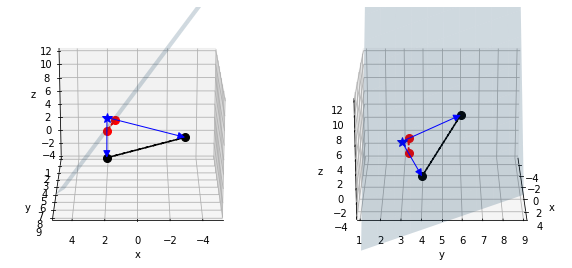

In [29]:
fig, axs = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(10,8))

xr = [-5,5]
yr = [1,9]
zr = [-2,6]
#need to set up mesh for plotting plane over range of x, y
x = np.linspace(xr[0],xr[1],50)
y = np.linspace(yr[0],yr[1],50)
X,Y = np.meshgrid(x,y)
Z = (d - a*X - b*Y) / c

# Plot the data
for ax in axs:
    ax.plot(lx, ly, lz, 'ko', linestyle="--")
    ax.plot(x_vals, y_vals, z_vals, 'ko', markersize=8)
    ax.plot(slx, sly, slz, 'ro', linestyle="--")
    ax.plot(x_vals1, y_vals1, z_vals1, 'ro', markersize=8)
    ax.plot(vc[0],vc[1],vc[2], 'b*', markersize=10)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    surf = ax.plot_surface(X, Y, Z, 
                        rstride=5, cstride=5,
                        alpha=0.2,
                        linewidth=0,
                        antialiased=True,
                        vmin=0
                          )
    ax.axes.set_xlim3d(left=xr[0], right=xr[1]) 
    ax.axes.set_ylim3d(bottom=yr[0], top=yr[1]) 
    ax.axes.set_zlim3d(bottom=2*zr[0], top=2*zr[1])
    arrow_prop_dict = dict(mutation_scale=15, arrowstyle='-|>', color='b', shrinkA=0, shrinkB=0, linewidth=1)
    ar1 = Arrow3D([vc[0], hp[0,0]], [vc[1], hp[1,0]], [vc[2], hp[2,0]], **arrow_prop_dict)
    ar2 = Arrow3D([vc[0], hp[0,1]], [vc[1], hp[1,1]], [vc[2], hp[2,1]], **arrow_prop_dict)
    ax.add_artist(ar1)
    ax.add_artist(ar2)

axs[0].view_init(elev=20., azim=90) 
axs[1].view_init(elev=20., azim=0)

plt.show()

In the image you can see two different angles showing the same thing. The light rays (blue arrows) travel from the viewing centre (blue sphere). 

## Projection using Python

The aim of this workbook has been to show you how the mathematics of projection you have learned in lectures translates into code, and to illustrate possible ways to view the projections that we carry out.

As we have seen in other workbooks, Python also includes specific routines which are related to the mathematics topics we encounter. Projection is no different.

Below is a simple routine which I found on the web which illustrates how Python itself can take different projections into account when it displays images on the screen for you. It is possible to specify the type of projection, and the focal length (which, in our course, is effectively the distance to the viewing centre).





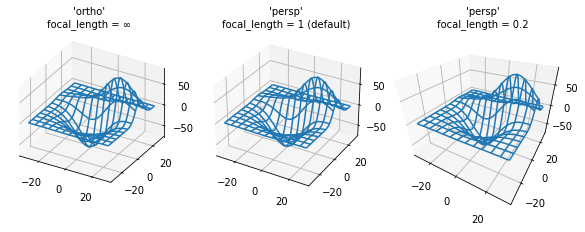

In [32]:
from mpl_toolkits.mplot3d import axes3d
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(10,8))

# Get the test data
X, Y, Z = axes3d.get_test_data(0.05)

# Plot the data
for ax in axs:
    ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)

# Set the orthographic projection.
axs[0].set_proj_type('ortho')  # FOV = 0 deg
axs[0].set_title("'ortho'\nfocal_length = ∞", fontsize=10)

# Set the perspective projections
axs[1].set_proj_type('persp')  # FOV = 90 deg
axs[1].set_title("'persp'\nfocal_length = 1 (default)", fontsize=10)

axs[2].set_proj_type('persp', focal_length=0.2)  # FOV = 157.4 deg
axs[2].set_title("'persp'\nfocal_length = 0.2", fontsize=10)

plt.show()

Note in the final image, the focal length has been reduced significantly, placing the viewing centre much closer to the 3D graph. This effectively makes the "near" part of the graph look a lot bigger, and the "far" part of the graph look smaller in the image. The lines on the walls on the plot are no longer parallel, as they have been distorted by the perspective projection.

Try playing with the focal length of the perspective projections. Do you notice the behaviour we discussed in class?